<div style="text-align: right"><i>Подготовил <a href="https://github.com/V1ad0S">Илларионов Владислав</a>

## Численное интегрирование систем ОДУ первого порядка методом Рунге-Кутты

Необходимо найти решение
$$ \frac{d\vec{x}}{dt} = \vec{f}(t, \vec{x}), \hspace{1cm} \vec{x} \in \mathbb{R}^n $$

удовлетворяющее начальному условию
$$ \vec{x}(t_0) = \vec{x}_0 $$


На примере одношагового *метода Рунге-Кутты* порядка $s$ с параметрами: $a_{ij}, b_i, c_i$, рассмотрим его распространение на системы при численном решении полученной выше задачи Коши.
$$ x_{m+1}^i = x^i(t_m + h) \approx x^i(t_m) + h \sum_{i=1}^s b_i k_{ij}(m) \hspace{1cm} i = \overline{1, n} $$

Здесь функции $k_{ij}(m)$ вычисляются по правилу:
$$ k_{i1}(m) = f_i(t_m, x^1, \ldots, x^n) $$

для $j = 2, \ldots, s$:
$$
k_{ij}(m) = f_i \left(t_m + c_j h, x^1 + \sum_{l=1}^{j-1}a_{jl}k_{1l}(m),\ldots, x^n + \sum_{l=1}^{j-1}a_{jl}k_{nl}(m)\right)
$$

Чтобы записать это решение в векторном виде, предварительно представим параметры метода в векторно-матричной форме:

$A$ -- матрица ($s \times s$) с элементами $a_{ij}$, $\vec{b}$ и $\vec{c}$ -- вектора из $\mathbb{R}^s$ с элементами $b_i$ и $c_i$ соответственно.

Тогда:
$$ \vec{x}_{m+1} = \vec{x}(t_m + h) \approx \vec{x}(t_m) + h \left(K(m) \cdot \vec{b} \right)$$

$K(m)$ -- матрица ($n \times s$) с элементами $k_{ij}(m)$.
Столбцы этой матрицы вектора $\left\{ \vec{k}_j \right\}_{j=1}^s$:
$$ \vec{k}_j = \vec{f}(t_m + c_j h, \vec{x}_n + \vec{p}(j, m))$$

Здесь вектор $\vec{p}$ отвечает за смещение аргумента функции $\vec{f}$:
$$ \vec{p}(j, m) = \left(\sum_{l=1}^{j-1}a_{jl}k_{1l}(m),\ldots, \sum_{l=1}^{j-1}a_{jl}k_{nl}(m) \right)^T $$

Методическая погрешность $\vec\sigma (h)$ -- вектор функция. Каждая ее компонента определяется равенством:
$$ \sigma^i (h) = \frac{\max\limits_{i \in [1, n]}|x_i^{(h)} - x_i^{(h/2)}|}{2^s - 1} $$

Чтобы найти решение системы с заданной точностью $\varepsilon$ необходимо добиться выполнения неравенства:
$$ \sigma^i < \varepsilon \hspace{1cm} \forall i \in [1, n] $$

Реализация представлена ниже

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def solve_odesystem(ode_system: 'cuple of functions-list and 1Darray initial conditions',
               RK_method: 'cuple of params-list like [A, b, c] and accuracy order',
               integration_segment: '[t_0, t_N]', N0, epsilon: 'accuracy' = 0):
    """Решает систему ОДУ с заданной точностью"""

    def runge_kutta_odesystem(ode_sys, rk_method, integration_seg, n):
        """Решает систему ОДУ методом Рунге-Кутты"""
        f, r0 = ode_sys
        (A, b, c), accuracy_order = rk_method
        sys_order = r0.size
        r = [r0]
        t_grid, h = np.linspace(*integration_seg, n, retstep=True)
        for n, tn in enumerate(t_grid[:-1]):
            K = np.array([[f[i](t=tn, r=r[n])] for i in range(sys_order)])
            for j in range(1, accuracy_order):
                p = np.array([A[j][:j] @ K[i] for i in range(sys_order)])
                Kj = np.array([f[i](t=(tn + c[j]*h), r=(r[n] + h*p)) for i in range(sys_order)])
                K = np.hstack([K, np.transpose([Kj])])
            r.append(r[n] + h*(K @ b))
        return t_grid, np.array(r)
    
    t_grid, r = runge_kutta_odesystem(ode_system, RK_method, integration_segment, N0)
    if epsilon:
        sigma = 2 * epsilon
        k = 1
        R = [r]
        while np.all(sigma > epsilon):
            k *= 2
            R.append(runge_kutta_odesystem(ode_system, RK_method, integration_segment, N*k - 1)[1][::k])
            diff = np.absolute(R[-2] - R[-1])
            sigma = diff.max(axis=0)/(2**rk_method[1] - 1)
        return t_grid, np.array(r), sigma
    return t_grid, np.array(r)

### Классический 4-стадийный метод РК 4-го порядка

In [3]:
c = np.array([0, 0.5, 0.5, 1])
b = np.array([1/6, 2/6, 2/6, 1/6])
A = np.array([[0  , 0  , 0, 0],
              [0.5, 0  , 0, 0],
              [0  , 0.5, 0, 0],
              [0  , 0  , 1, 0]])
accuracy_order = 4
rk_method = ([A, b, c], accuracy_order)

### Пример:

\begin{cases}
    \dot{x} = -y  \hspace{1cm} &x_0 = 1\\
    \dot{y} = x  &y_0 = 0\\
\end{cases}

Решением этой системы является:
\begin{cases}
    x = \cos t \\
    y = \sin t \\
\end{cases}

То есть, если построить график y(x), мы должны увидеть окружность

In [4]:
# r = [x, y]
# dx/dt = -y
def fx(*, t=0, r=[0, 0, 0]):
    r = np.array(r)
    return -r[1]
# dy/dt = x
def fy(*, t=0, r=[0, 0, 0]):
    r = np.array(r)
    return r[0]

# x(0) = 1, y(0) = 0
r0 = np.array([1, 0])
ode_system = ([fx, fy], r0)

# Интегрируем по всей окружности [0, 2pi]
integration_segment = [0, np.pi*2]
N = 100     # кол-во точек в сетке
epsilon = 1e-3 # точность
t, r, sigma = solve_odesystem(ode_system, rk_method, integration_segment, N, epsilon)
x, y = r.T

accuracy x(t): 4.113091413386153e-08
accuracy y(t): 5.301527154777386e-08


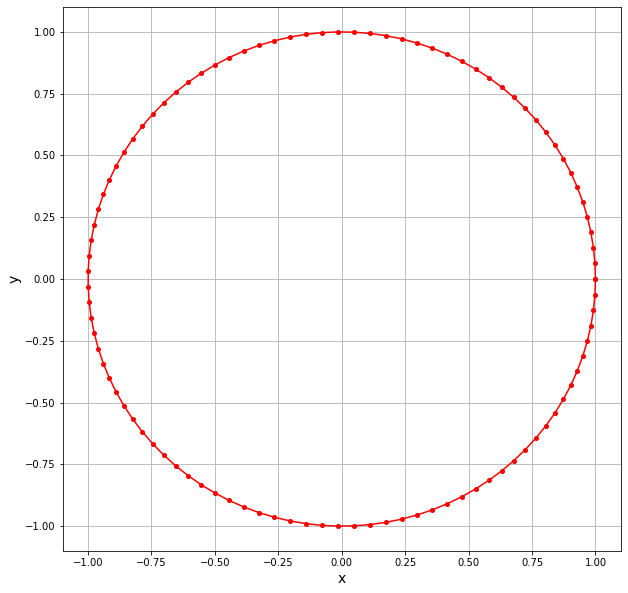

In [5]:
plt.figure(figsize=(10, 10))
plt.plot(x, y, 'o-r', markersize=4)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.grid()

print(f'accuracy x(t): {sigma[0]}')
print(f'accuracy y(t): {sigma[1]}')